In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
embedding_layer = layers.Embedding(1000, 5)

In [5]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[-0.00808321, -0.04808862,  0.0029536 , -0.03053421,  0.04072304],
       [-0.01099998,  0.02996132, -0.04160772, -0.02583643,  0.0228352 ],
       [ 0.04694391, -0.04295152, -0.00772163, -0.03013793,  0.0008713 ]],
      dtype=float32)

In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [9]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True, as_supervised=True
)

In [10]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [12]:
padded_shapes = ([None], ())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)

In [17]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[3216, 7961, 1205, ..., 3979, 3888,  782],
       [ 133,  724, 5080, ...,    0,    0,    0],
       [4435, 7886,  302, ...,    0,    0,    0],
       ...,
       [  12,   18, 1659, ...,    0,    0,    0],
       [7415, 3232,  104, ...,    0,    0,    0],
       [  62,    9,  419, ...,    0,    0,    0]])

In [33]:
train_batch.shape

TensorShape([10, 602])

In [19]:
embedding_dim = 16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.6374 - accuracy: 0.6875 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.4623 - accuracy: 0.8394 - val_loss: 0.4150 - val_accuracy: 0.8600
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.3603 - accuracy: 0.8779 - val_loss: 0.3625 - val_accuracy: 0.8800
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.3072 - accuracy: 0.8963 - val_loss: 0.4048 - val_accuracy: 0.8300
Epoch 5/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2720 - accuracy: 0.9067 - val_loss: 0.3049 - val_accuracy: 0.8850
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2505 - accuracy: 0.9148 - val_loss: 0.2960 - val_accuracy: 0.8600
Epoch 7/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2288 - accuracy: 0.9230 - val_loss: 0.2667 - val_

<Figure size 432x288 with 0 Axes>

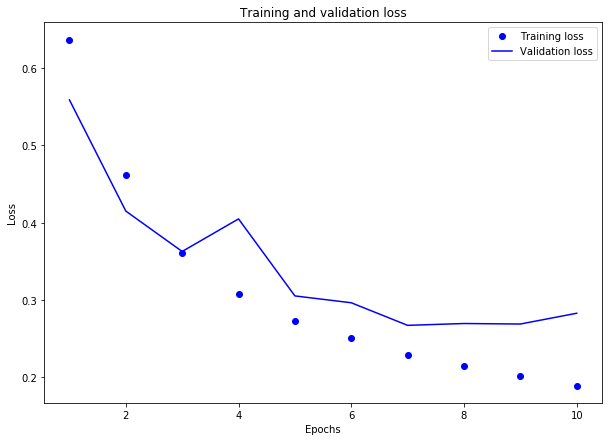

<Figure size 432x288 with 0 Axes>

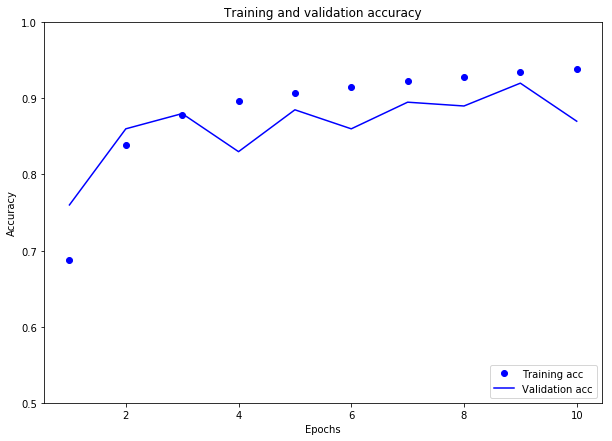

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.figure(figsize=(10,7))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [27]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


In [30]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
out_v.close()
out_m.close()